In [4]:
import numpy as np
import pandas as pd
import glob
import os
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D, Activation
from keras.optimizers import Adam
from keras.layers.convolutional import ZeroPadding2D

Using TensorFlow backend.


In [5]:
path = Path('chest_xray')
train_dir = path /'train'
test_dir = path / 'test'

In [6]:
Normal_dir_train = train_dir / 'NORMAL'
Pneumonia_dir_train = train_dir / 'PNEUMONIA'

Normal_dir_test = test_dir / 'NORMAL'
Pneumonia_dir_test = test_dir / 'PNEUMONIA'


In [7]:
print('Total training normal images: ', len(os.listdir(Normal_dir_train)))
print('Total training Pneumonia images: ', len(os.listdir(Pneumonia_dir_train)))

print('Total testing normal images: ', len(os.listdir(Normal_dir_test)))
print('Total testing Pneumonia images: ', len(os.listdir(Pneumonia_dir_test)))

Total training normal images:  1341
Total training Pneumonia images:  3875
Total testing normal images:  242
Total testing Pneumonia images:  398


In [8]:
normal_images = Normal_dir_train.glob('*.jpeg')
pneumonia_images = Pneumonia_dir_train.glob('*.jpeg')

normal_images_test = Normal_dir_test.glob('*.jpeg')
pneumonia_images_test = Pneumonia_dir_test.glob('*.jpeg')


In [9]:
def create_dataset(normal, pneumonia):
    df = []
    for i in normal:
        df.append((str(i), 'Normal')) #Normal cases are coded as 0
    for i in pneumonia:
        df.append((str(i), 'Pneumonia')) #Pneumonia cases are coded as 1
    set = pd.DataFrame(df, columns = ['image', 'label'], index = None)    
    return(set)

In [10]:
train_set = create_dataset(normal_images, pneumonia_images)
test_set = create_dataset(normal_images_test, pneumonia_images_test)

In [11]:
test_set.head()

,image,label
0,chest_xray\test\NORMAL\IM-0001-0001.jpeg,Normal
1,chest_xray\test\NORMAL\IM-0003-0001.jpeg,Normal
2,chest_xray\test\NORMAL\IM-0005-0001.jpeg,Normal
3,chest_xray\test\NORMAL\IM-0006-0001.jpeg,Normal
4,chest_xray\test\NORMAL\IM-0007-0001.jpeg,Normal


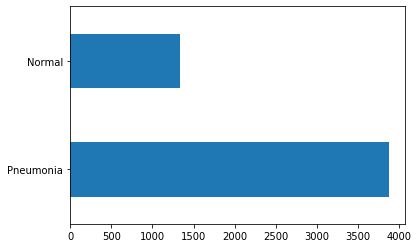

In [12]:
train_set['label'].value_counts().plot(kind = 'barh')

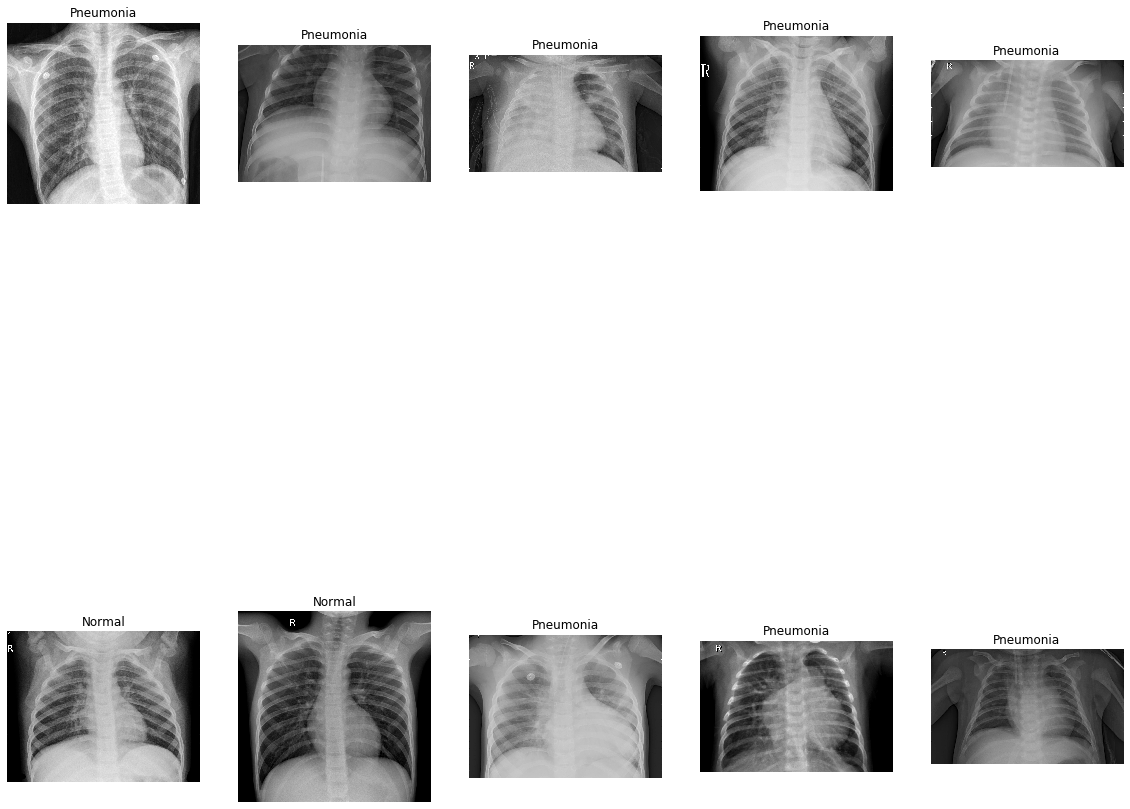

In [10]:
df_sample = train_set.sample(n = 10).reset_index() #Create random sample to display
plt.figure(figsize = (20,20))

for i in range(10):
    plt.subplot(2,5, i+1)
    img=mpimg.imread(df_sample.image[i])
    imgplot = plt.imshow(img, cmap = 'gray')
    plt.axis('off')
    if df_sample.label[i] == "0":
        plt.title('Normal')
    else:
        plt.title('Pneumonia')


In [49]:
#Image processing and Augmentation
batch_size = 32
IMG_HEIGHT = 150
IMG_WIDTH = 150

image_gen = ImageDataGenerator(validation_split=0.3,rescale=1./255, horizontal_flip=True, rotation_range = 45, width_shift_range=.15,
                    height_shift_range=.15)
train_data_gen = image_gen.flow_from_directory(directory = train_dir,
                                               subset = "training",
                                               seed = 100,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
                                               class_mode = 'binary')

val_data_gen = image_gen.flow_from_directory(directory = train_dir,
                                              subset = "validation",
                                               seed = 100,
                                               batch_size=batch_size,
                                               shuffle=True,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
                                               class_mode = 'binary')

test_data_gen = image_gen.flow_from_directory(directory = test_dir,
                                               seed = 100,
                                               batch_size=batch_size,
                                               shuffle=False,
                                               target_size=(IMG_HEIGHT, IMG_WIDTH),
                                               class_mode = 'binary')

Found 3652 images belonging to 2 classes.
Found 1564 images belonging to 2 classes.
Found 640 images belonging to 2 classes.


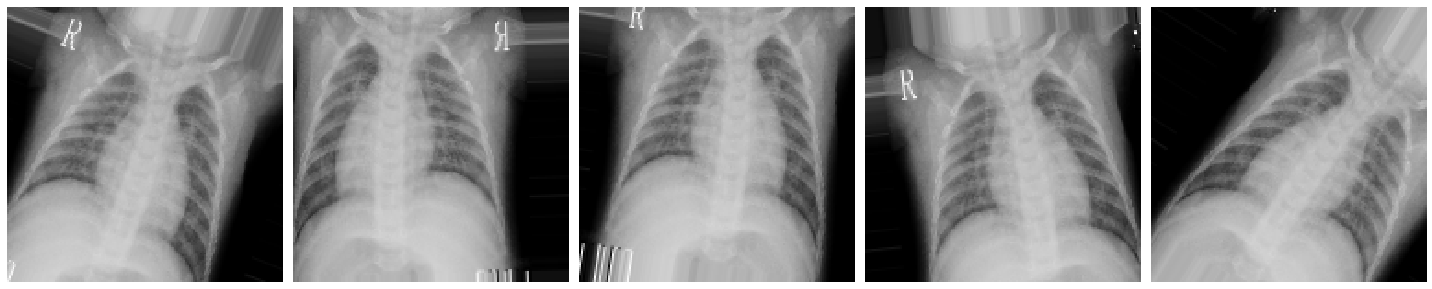

In [14]:
#Vizualize augmented image
augmented = [train_data_gen[0][0][0] for i in range(5)]
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

plotImages(augmented[:5])

In [54]:
#Model creation
model = Sequential([
    Conv2D(16, (3,3), padding='same', activation='relu', 
           input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Dropout(0.5),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Dropout(0.5),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(1, activation = 'sigmoid')])

# model.compile(loss='categorical_crossentropy',
#               optimizer='rmsprop',
#               metrics=['accuracy'])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 150, 150, 16)      448       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 75, 75, 16)        0         
_________________________________________________________________
dropout_16 (Dropout)         (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 75, 75, 32)        4640      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 37, 37, 64)        18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 18, 18, 64)       

In [55]:
epochs = 15
history = model.fit_generator(
    train_data_gen,
    steps_per_epoch=train_data_gen.n // train_data_gen.batch_size,
    epochs=epochs,
    validation_data=val_data_gen,
    validation_steps=val_data_gen.n // val_data_gen.batch_size)

Epoch 1/15
114/114 [==============================] - 295s 3s/step - loss: 0.5738 - accuracy: 0.7343 - val_loss: 0.5324 - val_accuracy: 0.7467
Epoch 2/15
114/114 [==============================] - 284s 2s/step - loss: 0.4514 - accuracy: 0.7497 - val_loss: 0.5019 - val_accuracy: 0.7507
Epoch 3/15
114/114 [==============================] - 254s 2s/step - loss: 0.4240 - accuracy: 0.7768 - val_loss: 0.4467 - val_accuracy: 0.7949
Epoch 4/15
114/114 [==============================] - 254s 2s/step - loss: 0.4039 - accuracy: 0.7992 - val_loss: 0.4563 - val_accuracy: 0.7663
Epoch 5/15
114/114 [==============================] - 252s 2s/step - loss: 0.3418 - accuracy: 0.8425 - val_loss: 0.4270 - val_accuracy: 0.8034
Epoch 6/15
114/114 [==============================] - 254s 2s/step - loss: 0.3052 - accuracy: 0.8652 - val_loss: 0.3691 - val_accuracy: 0.8503
Epoch 7/15
114/114 [==============================] - 252s 2s/step - loss: 0.2721 - accuracy: 0.8804 - val_loss: 0.2917 - val_accuracy: 0.8717

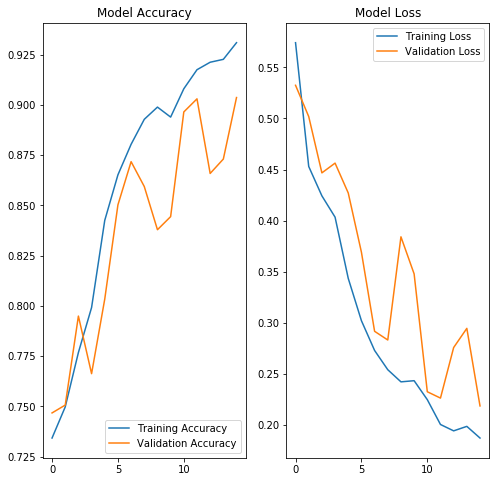

In [56]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Model Loss')
plt.show()

In [106]:
loss, acc_score = model.evaluate_generator(generator = test_data_gen, steps = test_data_gen.n// batch_size)
print("Accuracy of test set: {}%".format(round(acc_score,2)*100))

Accuracy of test set: 75.0%


In [58]:
test_data_gen.reset()
pred = model.predict_generator(test_data_gen, steps = test_data_gen.n// batch_size, verbose =1)

20/20 [==============================] - 34s 2s/step


In [64]:
predictions = np.where(pred<0.5,0,1)

In [72]:
from sklearn.metrics import accuracy_score, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

<Figure size 432x288 with 0 Axes>

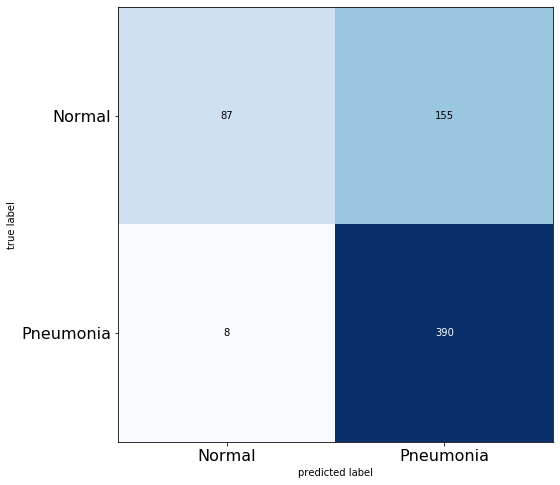

In [98]:
cm = confusion_matrix(test_data_gen.classes, predictions)
plt.figure()
plot_confusion_matrix(cm,figsize=(10,8), hide_ticks=True, cmap=plt.cm.Blues)
plt.xticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(range(2), ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [99]:
tn, fp, fn, tp = cm.ravel()

In [102]:
precision = tp/(tp+fp)*100
recall = tp/(tp+fn)*100
print('Precision: {}%'.format(round(precision,2)))
print('Recall: {}%'.format(round(recall,2)))
print('F1-score: {}'.format(round(2*precision*recall/(precision+recall),2)))


Precision: 71.56%
Recall: 97.99%
F1-score: 82.71
